# Entrenamiento de Detector de Placas - YOLOv8

Este notebook entrena un modelo YOLOv8 especializado en detectar placas vehiculares usando el dataset de Roboflow.

## Objetivos:
- Descargar dataset de placas desde Roboflow
- Entrenar modelo YOLOv8 con transfer learning
- Evaluar resultados
- Exportar modelo entrenado a `/models`

## 1. Instalacion de Dependencias

In [14]:
!pip install ultralytics roboflow -q

## 2. Importacion de Librerias

In [15]:
from roboflow import Roboflow
from ultralytics import YOLO
import os
from pathlib import Path
import shutil

## 3. Configuracion de Rutas

In [16]:
# Ruta base del proyecto (ajustar segun ubicacion)
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
MODELS_DIR = PROJECT_ROOT / 'models'
NOTEBOOKS_DIR = PROJECT_ROOT / 'notebooks'
RUNS_DIR = NOTEBOOKS_DIR / 'runs'

# Crear directorios si no existen (parents=True crea directorios padres)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
NOTEBOOKS_DIR.mkdir(parents=True, exist_ok=True)
RUNS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio del proyecto: {PROJECT_ROOT}")
print(f"Directorio de modelos: {MODELS_DIR}")
print(f"Directorio de entrenamiento: {RUNS_DIR}")

Directorio del proyecto: /content
Directorio de modelos: /content/models
Directorio de entrenamiento: /content/notebooks/runs


## 4. Descarga del Dataset desde Roboflow

In [17]:
# Inicializar Roboflow
rf = Roboflow(api_key="iDglqVEoYG9MkjGl3ZL3")
project = rf.workspace("dillonws").project("license-plate-az47f-j6wmy")
version = project.version(1)

# Descargar dataset en formato YOLOv8
# Roboflow crea una carpeta con el nombre del proyecto
dataset = version.download("yolov8")

print(f"Dataset descargado")
print(f"Ubicacion reportada: {dataset.location}")

# Buscar el directorio real del dataset
import os
current_dir = Path.cwd()
print(f"\nDirectorio actual: {current_dir}")
print("\nContenido del directorio actual:")
for item in current_dir.iterdir():
    if item.is_dir():
        print(f"  DIR: {item.name}")
        # Buscar data.yaml en cada directorio
        data_yaml_path = item / 'data.yaml'
        if data_yaml_path.exists():
            print(f"    -> Encontrado data.yaml aqui!")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-1 in yolov8:: 100%|██████████| 19156/19156 [00:03<00:00, 5351.37it/s]


Dataset descargado
Ubicacion reportada: /content/License-Plate-1

Directorio actual: /content

Contenido del directorio actual:
  DIR: .config
  DIR: notebooks
  DIR: License-Plate-1
    -> Encontrado data.yaml aqui!
  DIR: models
  DIR: sample_data


## 5. Verificacion del Dataset

In [18]:
# Buscar data.yaml en el directorio actual y subdirectorios
current_dir = Path.cwd()
yaml_files = list(current_dir.glob('*/data.yaml'))

if not yaml_files:
    # Buscar mas profundo
    yaml_files = list(current_dir.glob('**/data.yaml'))

if not yaml_files:
    raise FileNotFoundError("No se encontro data.yaml. Verifica la descarga de Roboflow.")

# Usar el primer data.yaml encontrado
data_yaml = yaml_files[0]
dataset_path = data_yaml.parent

print(f"Dataset encontrado en: {dataset_path}")
print(f"Archivo de configuracion: {data_yaml}")
print(f"\nContenido del directorio del dataset:")
for item in dataset_path.iterdir():
    print(f"  - {item.name}")

# Leer data.yaml
print(f"\nContenido de data.yaml:")
with open(data_yaml, 'r') as f:
    content = f.read()
    print(content)

print(f"\nRuta correcta del data.yaml: {data_yaml}")

Dataset encontrado en: /content/License-Plate-1
Archivo de configuracion: /content/License-Plate-1/data.yaml

Contenido del directorio del dataset:
  - README.dataset.txt
  - valid
  - README.roboflow.txt
  - data.yaml
  - train
  - test

Contenido de data.yaml:
names:
- '------------------------------'
- LicensePlate - v2 2023-12-02 3-27pm
- This dataset was exported via roboflow.com on March 5- 2024 at 8-02 AM GMT
- experiment-plates - v1 2024-06-08 11-54am
- license plate detection - v1 2024-04-05 7-01pm
nc: 5
roboflow:
  license: CC BY 4.0
  project: license-plate-az47f-j6wmy
  url: https://universe.roboflow.com/dillonws/license-plate-az47f-j6wmy/dataset/1
  version: 1
  workspace: dillonws
test: ../test/images
train: ../train/images
val: ../valid/images


Ruta correcta del data.yaml: /content/License-Plate-1/data.yaml


## 6. Carga del Modelo Base YOLOv8

Usaremos YOLOv8n (nano) como base para transfer learning. Es rapido y eficiente para detectar placas.

In [19]:
# Cargar modelo pre-entrenado YOLOv8n
model = YOLO('yolov8n.pt')

print("Modelo YOLOv8n cargado correctamente")
print(f"Arquitectura: {model.model}")

Modelo YOLOv8n cargado correctamente
Arquitectura: DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=T

## 7. Configuracion de Parametros de Entrenamiento

In [20]:
# Parametros de entrenamiento
EPOCHS = 50  # Ajustar segun tiempo disponible y convergencia
BATCH_SIZE = 16  # Ajustar segun memoria GPU disponible
IMAGE_SIZE = 640  # Tamano de imagen estandar para YOLO
PATIENCE = 10  # Early stopping

training_config = {
    'data': str(data_yaml),  # Usa la variable data_yaml corregida
    'epochs': EPOCHS,
    'batch': BATCH_SIZE,
    'imgsz': IMAGE_SIZE,
    'patience': PATIENCE,
    'project': str(RUNS_DIR),
    'name': 'plate_detector',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'auto',
    'verbose': True,
    'seed': 42,
    'device': 0,
}

print("Configuracion de entrenamiento:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

Configuracion de entrenamiento:
  data: /content/License-Plate-1/data.yaml
  epochs: 50
  batch: 16
  imgsz: 640
  patience: 10
  project: /content/notebooks/runs
  name: plate_detector
  exist_ok: True
  pretrained: True
  optimizer: auto
  verbose: True
  seed: 42
  device: 0


## 8. Entrenamiento del Modelo

In [21]:
# Iniciar entrenamiento
results = model.train(**training_config)

print("\nEntrenamiento completado")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/License-Plate-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plate_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=Tr

## 9. Evaluacion del Modelo

In [22]:
# Evaluar modelo en conjunto de validacion
metrics = model.val()

print("\nMetricas de validacion:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1170.0±1059.9 MB/s, size: 40.7 KB)
val: Scanning /content/License-Plate-1/valid/labels.cache... 979 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 979/979 1.2Mit/s 0.0s
val: /content/License-Plate-1/valid/images/Image_15_png_jpg.rf.3e64eda32aa2152533ee2faa3e997ad0.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 864, len(boxes) = 1140. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 5.2it/s 11.9s
                   all        979       1140      0.563      0.793      0.613       

## 10. Visualizacion de Resultados

Curvas de entrenamiento:


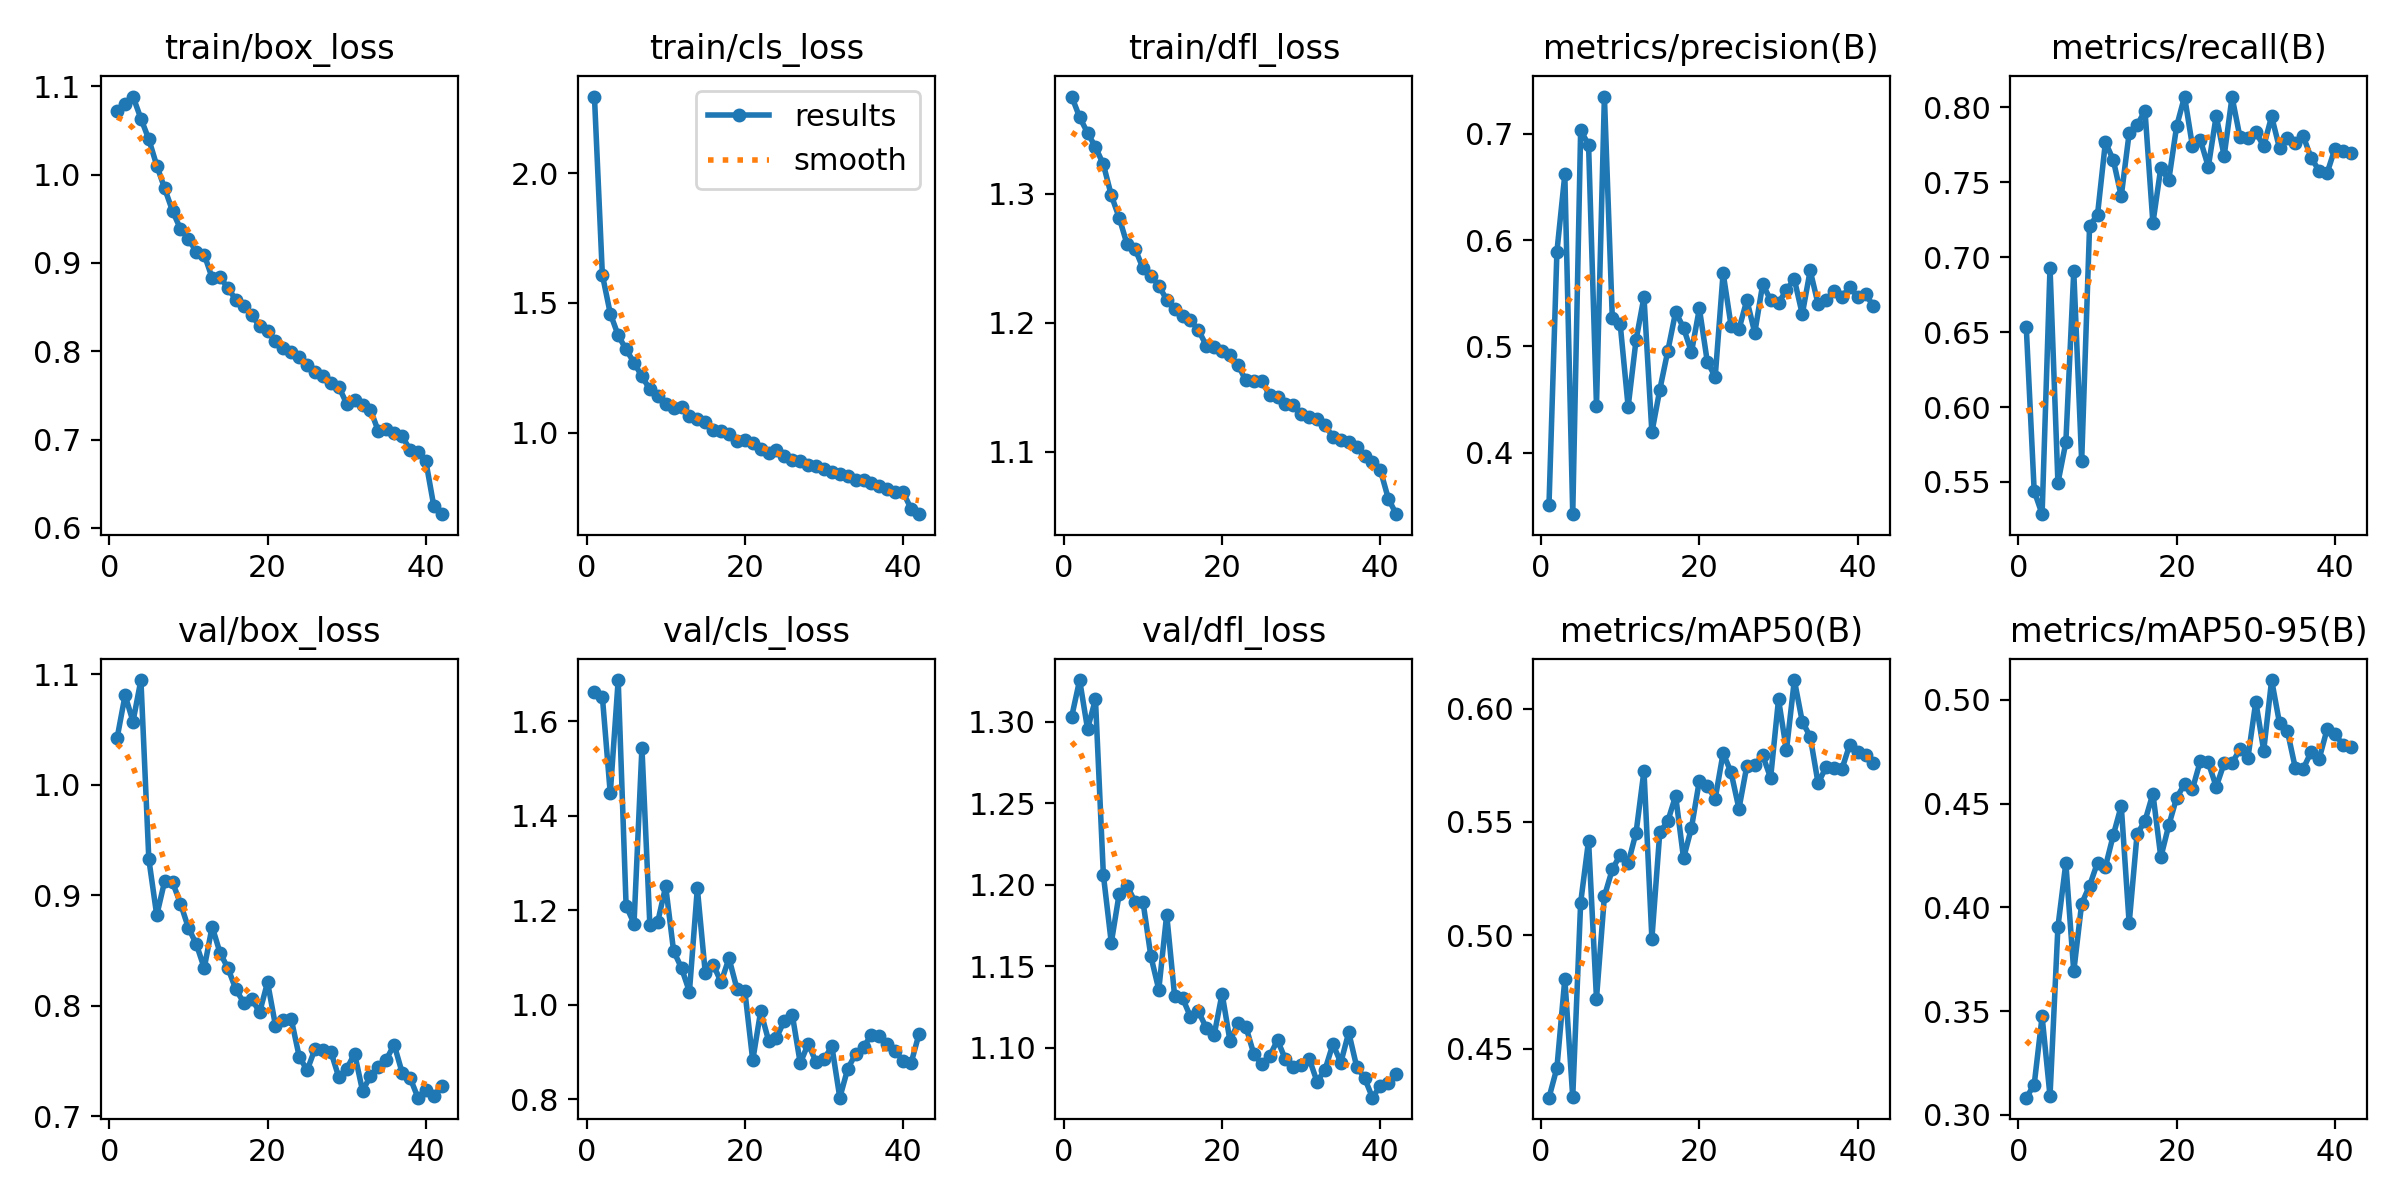


Matriz de confusion:


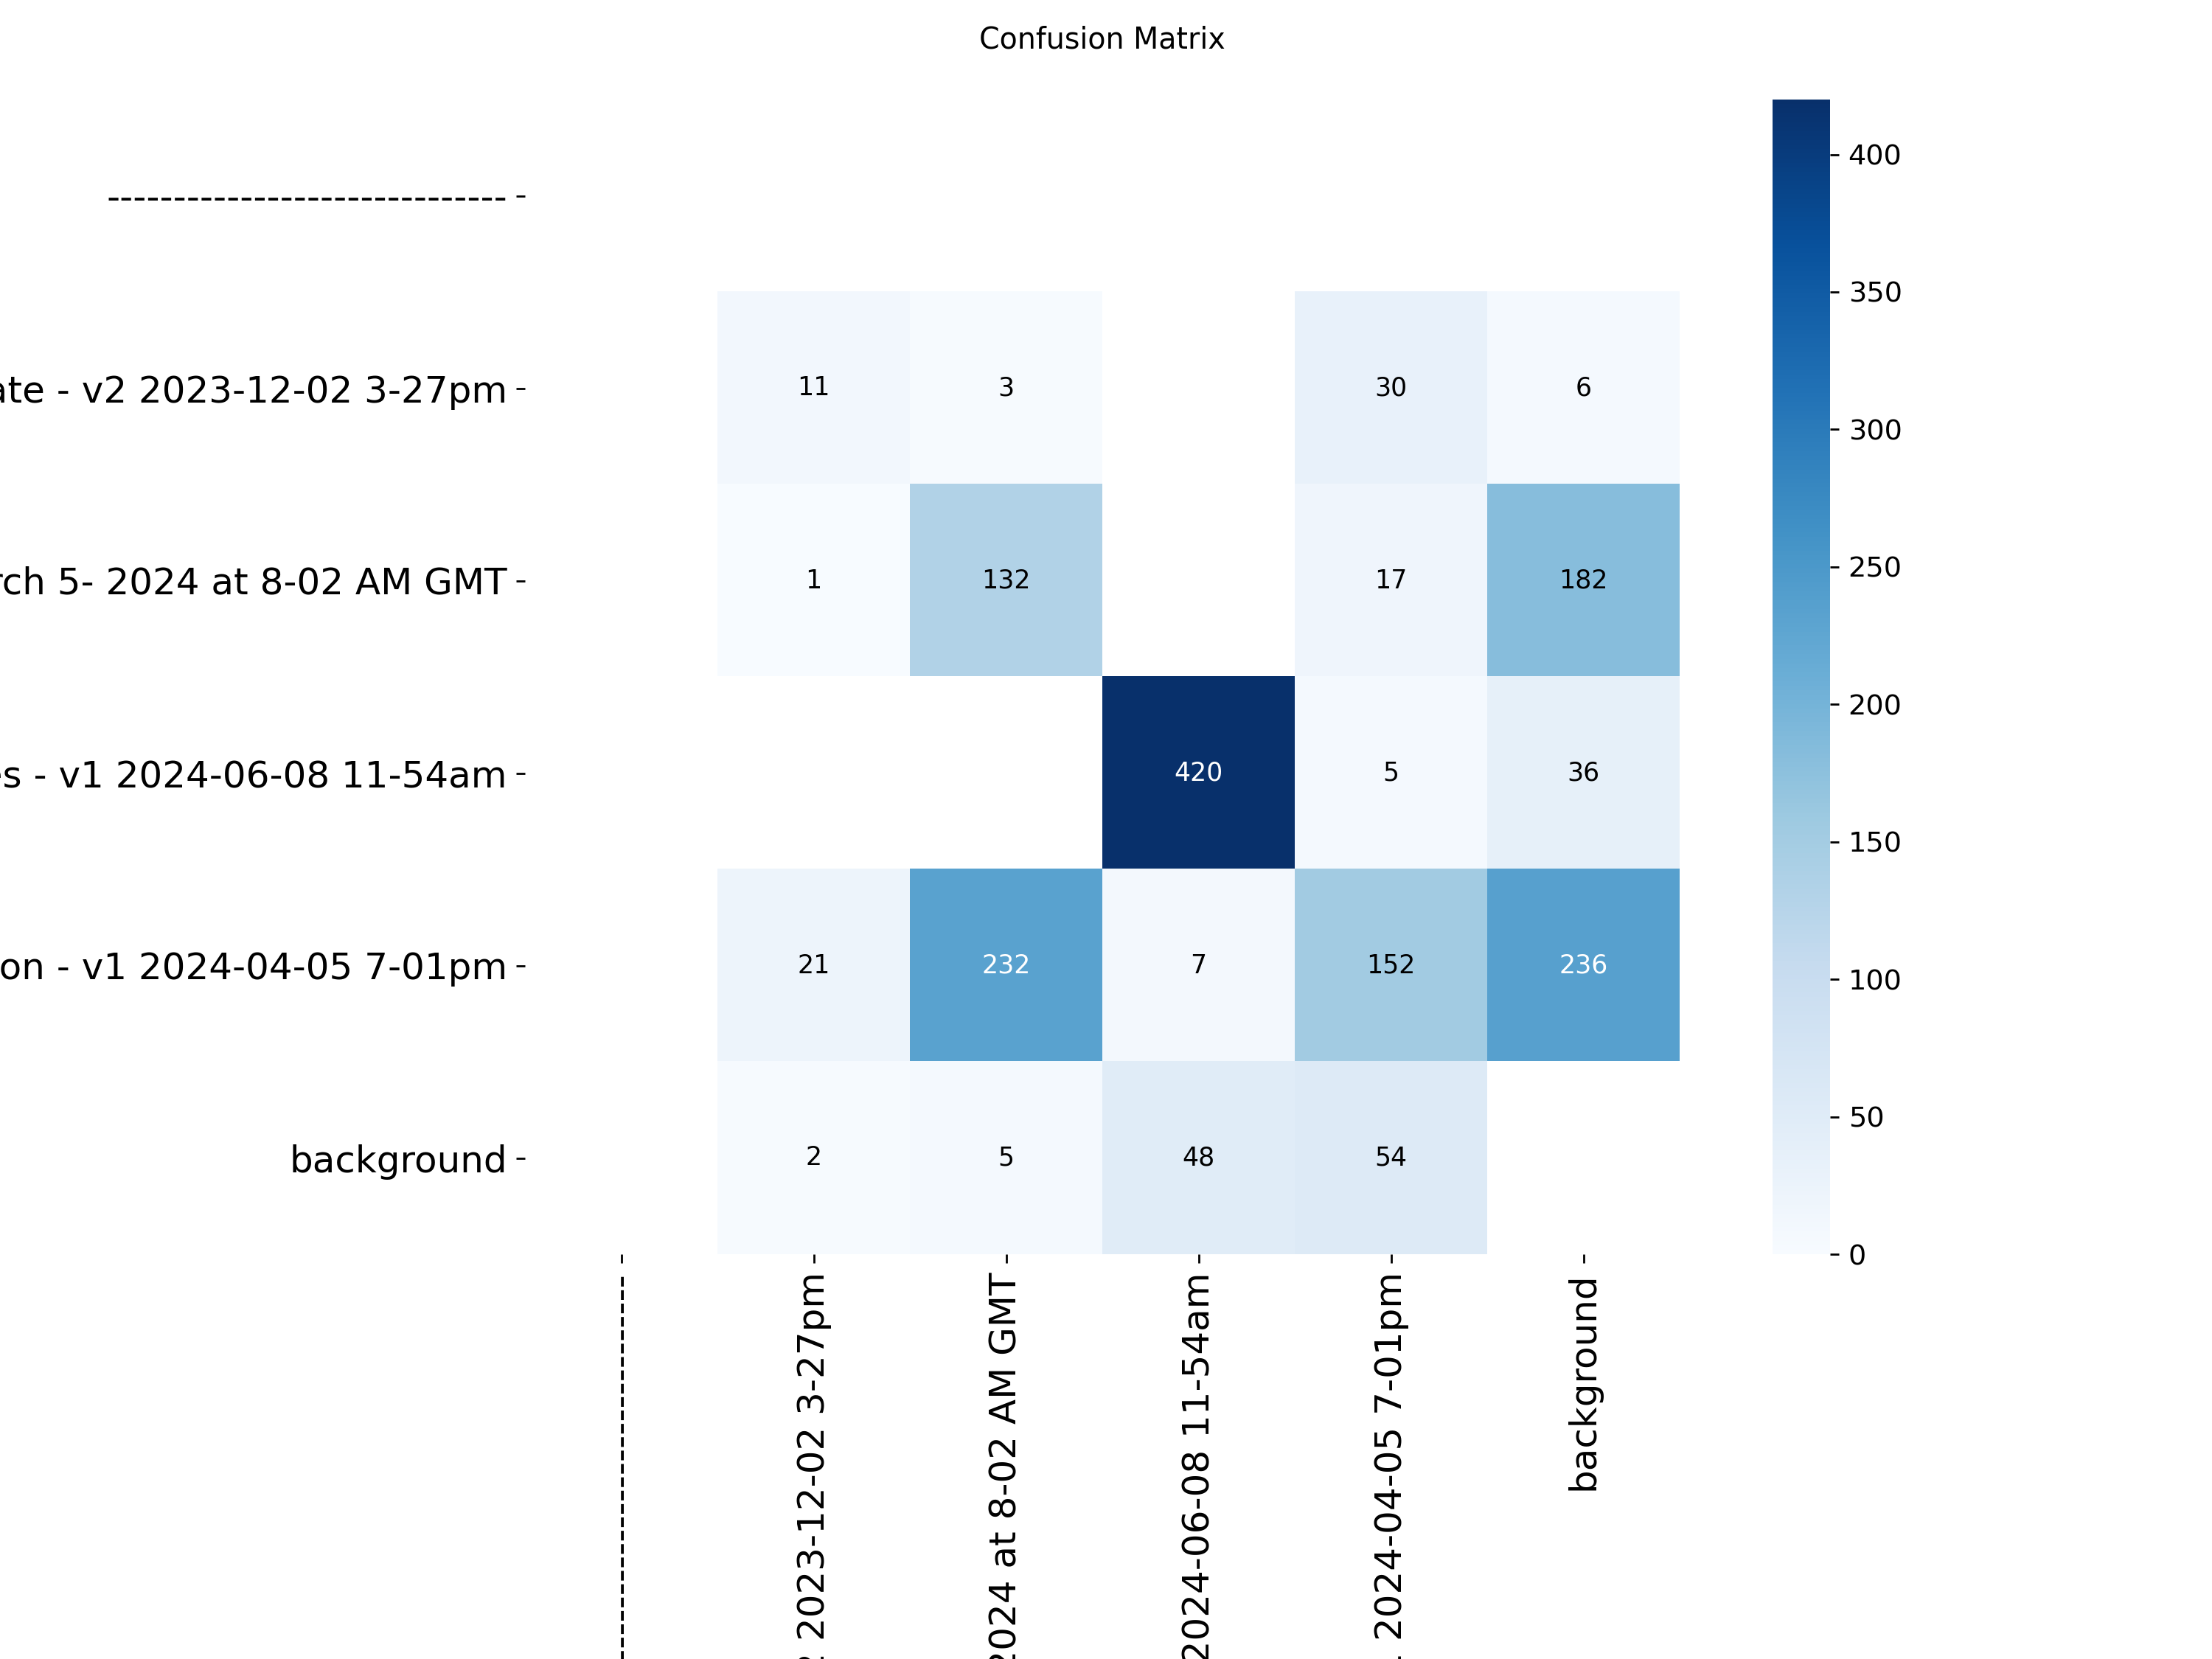

In [23]:
from IPython.display import Image, display

# Mostrar curvas de entrenamiento
results_dir = RUNS_DIR / 'plate_detector'
results_img = results_dir / 'results.png'

if results_img.exists():
    print("Curvas de entrenamiento:")
    display(Image(filename=str(results_img)))

# Mostrar matriz de confusion
confusion_matrix = results_dir / 'confusion_matrix.png'
if confusion_matrix.exists():
    print("\nMatriz de confusion:")
    display(Image(filename=str(confusion_matrix)))

## 11. Prueba del Modelo Entrenado

In [24]:
# Cargar mejor modelo entrenado
best_model_path = results_dir / 'weights' / 'best.pt'
trained_model = YOLO(str(best_model_path))

# Probar con imagenes de validacion
val_images_dir = dataset_path / 'valid' / 'images'
if val_images_dir.exists():
    test_images = list(val_images_dir.glob('*.jpg'))[:5]  # Primeras 5 imagenes

    print(f"Probando con {len(test_images)} imagenes de validacion...")

    for img_path in test_images:
        results = trained_model.predict(source=str(img_path), save=True, conf=0.25)
        print(f"  Procesada: {img_path.name}")

    print(f"\nResultados guardados en: {results_dir / 'predict'}")

Probando con 5 imagenes de validacion...

image 1/1 /content/License-Plate-1/valid/images/og0495u1j0ca1_jpg.rf.6ecdbea897d9beabdcb3ed5f067ae7ee.jpg: 640x640 1 license plate detection - v1 2024-04-05 7-01pm, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
  Procesada: og0495u1j0ca1_jpg.rf.6ecdbea897d9beabdcb3ed5f067ae7ee.jpg

image 1/1 /content/License-Plate-1/valid/images/225_jpg.rf.1b1f5fa37e45970c8d6b09dd17947537.jpg: 640x640 1 experiment-plates - v1 2024-06-08 11-54am, 7.5ms
Speed: 4.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
  Procesada: 225_jpg.rf.1b1f5fa37e45970c8d6b09dd17947537.jpg

image 1/1 /content/License-Plate-1/valid/images/qwmd0qj54tla1_jpg.rf.59fc927484694d8706a398d6ecc888eb.jpg: 640x640 1 license plate detection - v1 2024-04-05 7-01pm, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 

## 12. Exportacion del Modelo Final

In [25]:
# Copiar mejor modelo a carpeta /models
final_model_name = 'yolov8_plate_detector.pt'
final_model_path = MODELS_DIR / final_model_name

shutil.copy2(best_model_path, final_model_path)

print(f"Modelo exportado exitosamente a: {final_model_path}")
print(f"Tamano del archivo: {final_model_path.stat().st_size / 1024 / 1024:.2f} MB")

# Verificar que el modelo se puede cargar
verification_model = YOLO(str(final_model_path))
print("\nVerificacion: Modelo cargado correctamente desde /models")

Modelo exportado exitosamente a: /content/models/yolov8_plate_detector.pt
Tamano del archivo: 5.96 MB

Verificacion: Modelo cargado correctamente desde /models


## 13. Resumen y Proximos Pasos

In [26]:
print("=" * 60)
print("RESUMEN DEL ENTRENAMIENTO")
print("=" * 60)
print(f"\nModelo base: YOLOv8n")
print(f"Dataset: Roboflow - License Plate Detection")
print(f"Epocas entrenadas: {EPOCHS}")
print(f"\nModelo final guardado en:")
print(f"  {final_model_path}")
print(f"\nMetricas finales:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")
print(f"\nProximos pasos:")
print("  1. Actualizar src/plate_recognizer.py para usar este modelo")
print("  2. Integrar en el pipeline de deteccion")
print("  3. Probar con imagenes reales de vehiculos peruanos")
print("  4. Ajustar umbral de confianza segun necesidad")
print("=" * 60)

RESUMEN DEL ENTRENAMIENTO

Modelo base: YOLOv8n
Dataset: Roboflow - License Plate Detection
Epocas entrenadas: 50

Modelo final guardado en:
  /content/models/yolov8_plate_detector.pt

Metricas finales:
  mAP50: 0.6128
  mAP50-95: 0.5096
  Precision: 0.5634
  Recall: 0.7934

Proximos pasos:
  1. Actualizar src/plate_recognizer.py para usar este modelo
  2. Integrar en el pipeline de deteccion
  3. Probar con imagenes reales de vehiculos peruanos
  4. Ajustar umbral de confianza segun necesidad


## Notas Importantes

### Uso del Modelo en Produccion

```python
from ultralytics import YOLO

# Cargar modelo entrenado
model = YOLO('models/yolov8_plate_detector.pt')

# Detectar placas en imagen
results = model.predict(source='imagen.jpg', conf=0.25)

# Extraer coordenadas de placas detectadas
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        # Recortar placa de imagen original
```

### Ajustes Posibles

- **Epocas**: Aumentar si el modelo no converge
- **Batch size**: Reducir si hay problemas de memoria
- **Confianza**: Ajustar umbral de deteccion (0.25 default)
- **Data augmentation**: Roboflow ya aplica augmentations
- **Modelo base**: Probar yolov8s.pt o yolov8m.pt para mejor precision

### Integracion con EasyOCR

Este modelo detecta la ubicacion de la placa. Luego se debe:
1. Recortar la region detectada
2. Pasar el recorte a EasyOCR para leer el texto
3. Post-procesar el texto (eliminar espacios, validar formato)